In [151]:
# One-dimension, with K^, one bottle test
# Simulation for Lee et al., 2019 Nature

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statistics as st
import random
from scipy import stats
from matplotlib import gridspec



In [168]:
N_i = 100# Number of iterations in a set
N_exp = 100# Number of sets of iterations; same as simulation 1

# Parameters ########################

alp_Kh = 0.3# Learning rate (alpha) of K^
alp_Q = 0.03# Learning rate (alpha) of Q
beta = 10# Inverse temperature
tau = 7000# Attenuation rate

mouth = 0.2# Volume of one intake

##################################
fs = 18# Font size
rd = 0.1# Error region density

fig = plt.figure()

<Figure size 432x288 with 0 Axes>

In [169]:
class Gen:
    def __init__(self, init_H=0, Kh_a0=0, Kh_a1=mouth):
        self.N = N_i
        self.a = np.zeros(self.N)# Actions; 0(Do nothing) or 1(Saltwater intake)
        self.D = np.zeros(self.N+1)# D(H_t)
        self.D_est = np.zeros(self.N+1)# D(H_t+1)
        self.H = np.zeros(self.N+1)# Sodium state
        self.H_ast = 50# Setpoint (i.e., the ideal point)
        self.P = np.zeros(self.N)# Probability of intake
        self.K = np.zeros(self.N)# Volume per intake
        self.Kh = np.zeros((2, self.N+1))# K^ (Prediction of increase of internal state)        
        self.Q = np.zeros((2, self.N+1))# Action values
        self.R = np.zeros(self.N)# Reward
        
        self.m = 3# A constant of the homeostatic space
        self.n = 4# The other constant of the homeostatic space
        
        self.alp_Kh = alp_Kh
        self.alp_Q = alp_Q
        self.beta = beta
        self.tau = tau
        self.mouth = mouth
        
        # Initializations
        self.H[0] = init_H
        self.Kh_a0 = Kh_a0
        self.Kh_a1 = Kh_a1
        
        
    def softmax(self, t):# a0: Do nothing, a1: Intake
        self.t = t
        sigma = np.exp(self.Q[0][self.t]*self.beta) + np.exp(self.Q[1][self.t]*self.beta)
        vals = []
        for g in range(2):
            softmax = np.exp(self.Q[g][self.t]*self.beta)/sigma
            vals.append(softmax)
            if g == 1:
                self.P[self.t] = softmax
            
        dice = random.random()# Random from 0~1
        if dice <= vals[0]:
            self.a[self.t] = 0
        elif vals[0] < dice:
            self.a[self.t] = 1
            
    def get_Kh(self, t):
        self.t = t
        if self.a[self.t] == 0:# Do nothing
            self.K[self.t] = 0
            self.Kh[0][self.t+1] = (1 - self.alp_Kh)*self.Kh[0][self.t] + self.alp_Kh*self.Kh_a0
            self.Kh[1][self.t+1] = self.Kh[1][self.t]
            
        else:# Saltwater intake
            self.K[self.t] = self.mouth
            self.Kh[0][self.t+1] = self.Kh[0][self.t]
            self.Kh[1][self.t+1] = (1 - self.alp_Kh)*self.Kh[1][self.t] + self.alp_Kh*self.Kh_a1
            
    def get_D(self, t):
        self.t = t
        self.D[self.t] =  (abs(self.H_ast - self.H[self.t])**self.n)**(1/self.m)
        if self.a[self.t] == 0:
            self.D_est[self.t] = (abs(self.H_ast - (1 - 1/self.tau) * self.H[self.t]
                                      - self.Kh[0][self.t+1])**self.n)**(1/self.m)
        else:
            self.D_est[self.t] = (abs(self.H_ast - (1 - 1/self.tau) * self.H[self.t]
                                      - self.Kh[1][self.t+1])**self.n)**(1/self.m)


    def get_R(self, t):
        self.t = t
        self.R[self.t] = self.D[self.t] - self.D_est[self.t]
            
    
    def get_H(self, t):
        self.t = t
        self.H[self.t+1] = (1 - 1/self.tau) * self.H[self.t] + self.K[self.t]
            
            
    def get_Q(self, t):
        self.t = t
        if self.a[self.t] == 0:
            self.Q[0][self.t+1] = self.Q[0][self.t] + self.alp_Q*(self.R[self.t] - self.Q[0][self.t])
            self.Q[1][self.t+1] = self.Q[1][self.t]
            
        elif self.a[self.t] == 1:
            self.Q[0][self.t+1] = self.Q[0][self.t]
            self.Q[1][self.t+1] = self.Q[1][self.t] + self.alp_Q*(self.R[self.t] - self.Q[1][self.t])

        


In [170]:
# Control group
#--------------------------
num_l =  list(range(N_i+1))
N_exp_l = list(range(N_exp))

a_H = np.zeros(N_exp * (N_i+1))
a_Q0 = np.zeros(N_exp * (N_i+1))
a_Q1 = np.zeros(N_exp * (N_i+1))

a_P = np.zeros(N_exp * (N_i+1))
a_a = np.zeros(N_exp * (N_i+1))
a_R = np.zeros(N_exp * (N_i+1))

a_Kh0 = np.zeros(N_exp * (N_i+1))
a_Kh1 = np.zeros(N_exp * (N_i+1))

class_l = []# List for classes

#To make list of Classes
for i in range(N_exp):
    class_l.append(None)


#main
for j in range(N_exp):
    class_l[j] = Gen()
    for i in range(N_i):
        class_l[j].softmax(i)
        class_l[j].get_Kh(i)
        class_l[j].get_D(i)
        class_l[j].get_R(i)
        class_l[j].get_H(i)
        class_l[j].get_Q(i)



    
    a_H[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].H
    a_Q0[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].Q[0]
    a_Q1[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].Q[1]
    a_P[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(class_l[j].P, np.nan)
    a_a[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(class_l[j].a, np.nan)
    a_R[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(class_l[j].R, np.nan)
    a_Kh0[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].Kh[0]
    a_Kh1[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].Kh[1]

                   
df = pd.DataFrame(data=list(range((N_i+1))) * N_exp, columns=['trial'])
df['H'] = a_H
df['Q0'] = a_Q0
df['Q1'] = a_Q1
df['P'] = a_P
df['A'] = a_a
df['R'] = a_R
df['Kh0'] = a_Kh0
df['Kh1'] = a_Kh1



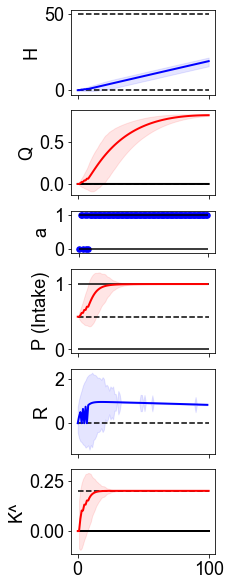

In [182]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams["font.size"] = 18
fig = plt.figure(figsize=(4,10))


spec = gridspec.GridSpec(ncols=1, nrows=6, height_ratios=[2,2,1,2,2,2])


ax_l = []
ax_l.append(fig.add_subplot(spec[0]))
ax_l.append(fig.add_subplot(spec[1]))
ax_l.append(fig.add_subplot(spec[2]))
ax_l.append(fig.add_subplot(spec[3]))
ax_l.append(fig.add_subplot(spec[4]))
ax_l.append(fig.add_subplot(spec[5]))

CL = 0.95# Confidencial Level for Figures
Df = N_exp-1# degree of freedom for Figures

mean = [] #mean at t
STD = []
#SE = []# Standard Error for Figures
CI = np.zeros((7, N_i+1, 2)) #confidence intervals at t


for j, h in zip(['H','Q0','Q1','P','R', 'Kh0','Kh1'], list(range(7))):
    for i in range(N_i+1):
        mean.append(sum(df.loc[df['trial']==i][j])/N_exp)
        STD.append(st.stdev(df.loc[df['trial']==i][j]))
        CI[h][i][0] = stats.t.interval(alpha = CL, df = Df, loc = mean[-1], scale = 2*STD[-1])[0]
        CI[h][i][1] = stats.t.interval(alpha = CL, df = Df, loc = mean[-1], scale = 2*STD[-1])[1]
        
         
length_l, length_s = N_i+1, N_i


ax_l[0].hlines(50, 0, N_i, linestyle="dashed")
ax_l[0].hlines(0, 0, N_i, linestyle="dashed")
ax_l[0].plot(df['H'][:length_l], linewidth=2, color='blue')
ax_l[0].fill_between(df.index[:length_l], CI[0, :, 0], CI[0, :, 1], color='blue', alpha=rd) #confidence interval curves.
ax_l[0].set_ylabel('H', fontsize=fs, fontname='Arial')
ax_l[0].tick_params(labelbottom=False)


ax_l[1].hlines(0, 0, N_i, linestyle="dashed")
ax_l[1].plot(df['Q0'][:length_l], linewidth=2, color='black')
ax_l[1].fill_between(df.index[:length_l], CI[1, :, 0], CI[1, :, 1], color='black', alpha=rd) #confidence interval curves.
ax_l[1].plot(df['Q1'][:length_l], linewidth=2, color='red')
ax_l[1].fill_between(df.index[:length_l], CI[2, :, 0], CI[2, :, 1], color='red', alpha=rd) #confidence interval curves.
ax_l[1].set_ylabel('Q' , fontsize=fs, fontname='Arial')
ax_l[1].tick_params(labelbottom=False)


ax_l[2].hlines(1, 0, N_i)
ax_l[2].hlines(0, 0, N_i)
ax_l[2].scatter(list(range(length_s)), df['A'][:length_s], s=30, c='blue')
ax_l[2].set_ylabel('a' , fontsize=fs, fontname='Arial')
ax_l[2].tick_params(labelbottom=False)


ax_l[3].hlines(0, 0, N_i)
ax_l[3].hlines(0.5, 0, N_i,  linestyle="dashed")
ax_l[3].hlines(1, 0, N_i)
ax_l[3].plot(df['P'][:length_s], linewidth=2, color='red')
ax_l[3].fill_between(df.index[:length_s], CI[3, :, 0][:length_s], CI[3, :, 1][:length_s], color='red', alpha=rd) #confidence interval curves.
ax_l[3].set_ylabel('P (Intake)' , fontsize=fs, fontname='Arial')
ax_l[3].tick_params(labelbottom=False)


ax_l[4].hlines(0, 0, N_i, linestyle="dashed")
ax_l[4].plot(df['R'][:length_s], linewidth=2, color='blue')
ax_l[4].fill_between(df.index[:length_s], CI[4, :, 0][:length_s], CI[4, :, 1][:length_s], color='blue', alpha=rd) #confidence interval curves.
ax_l[4].set_ylabel('R' , fontsize=fs, fontname='Arial')
ax_l[4].tick_params(labelbottom=False)

ax_l[5].hlines(0, 0, N_i, linestyle="dashed")
ax_l[5].hlines(mouth, 0, N_i, linestyle="dashed")
ax_l[5].plot(df['Kh0'][:length_l], linewidth=2, color='black')
ax_l[5].fill_between(df.index[:length_l], CI[5, :, 0], CI[5, :, 1], color='black', alpha=rd) #confidence interval curves.
ax_l[5].plot(df['Kh1'][:length_l], linewidth=2, color='red')
ax_l[5].fill_between(df.index[:length_l], CI[6, :, 0], CI[6, :, 1], color='red', alpha=rd) #confidence interval curves.
ax_l[5].set_ylabel('K^' , fontsize=fs, fontname='Arial')
#ax_l[5].tick_params(labelbottom=False)

fig.subplots_adjust(left=0.4)
fig.savefig("Fig2_control.png")


In [186]:

#--------------------------
# Intragastric infusion group

ig_num_l =  list(range(N_i+1))
ig_N_exp_l = list(range(N_exp))

ig_a_H = np.zeros(N_exp * (N_i+1))
ig_a_Q0 = np.zeros(N_exp * (N_i+1))
ig_a_Q1 = np.zeros(N_exp * (N_i+1))

ig_a_P = np.zeros(N_exp * (N_i+1))
ig_a_a = np.zeros(N_exp * (N_i+1))
ig_a_R = np.zeros(N_exp * (N_i+1))

ig_a_Kh0 = np.zeros(N_exp * (N_i+1))
ig_a_Kh1 = np.zeros(N_exp * (N_i+1))

ig_class_l = []# List for classes

#To make list of Classes
for i in range(N_exp):
    ig_class_l.append(None)


#main
for j in range(N_exp):
    ig_class_l[j] = Gen(init_H=25)########
    for i in range(N_i):
        ig_class_l[j].softmax(i)
        ig_class_l[j].get_Kh(i)
        ig_class_l[j].get_D(i)
        ig_class_l[j].get_R(i)
        ig_class_l[j].get_H(i)
        ig_class_l[j].get_Q(i)



    
    ig_a_H[(N_i+1)*j : (N_i+1)*(j+1)] = ig_class_l[j].H
    ig_a_Q0[(N_i+1)*j : (N_i+1)*(j+1)] = ig_class_l[j].Q[0]
    ig_a_Q1[(N_i+1)*j : (N_i+1)*(j+1)] = ig_class_l[j].Q[1]
    ig_a_P[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(ig_class_l[j].P, np.nan)
    ig_a_a[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(ig_class_l[j].a, np.nan)
    ig_a_R[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(ig_class_l[j].R, np.nan)
    ig_a_Kh0[(N_i+1)*j : (N_i+1)*(j+1)] = ig_class_l[j].Kh[0]
    ig_a_Kh1[(N_i+1)*j : (N_i+1)*(j+1)] = ig_class_l[j].Kh[1]

                   
ig_df = pd.DataFrame(data=list(range((N_i+1))) * N_exp, columns=['trial'])
ig_df['H'] = ig_a_H
ig_df['Q0'] = ig_a_Q0
ig_df['Q1'] = ig_a_Q1
ig_df['P'] = ig_a_P
ig_df['A'] = ig_a_a
ig_df['R'] = ig_a_R
ig_df['Kh0'] = ig_a_Kh0
ig_df['Kh1'] = ig_a_Kh1



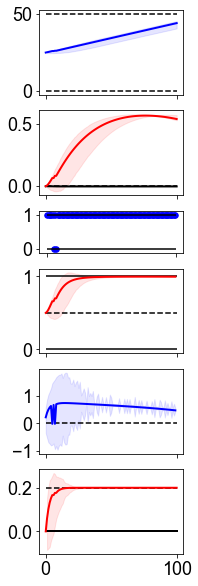

In [189]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams["font.size"] = 18
ig_fig = plt.figure(figsize=(4,10))


ig_spec = gridspec.GridSpec(ncols=1, nrows=6, height_ratios=[2,2,1,2,2,2])


ig_ax_l = []
ig_ax_l.append(ig_fig.add_subplot(ig_spec[0]))
ig_ax_l.append(ig_fig.add_subplot(ig_spec[1]))
ig_ax_l.append(ig_fig.add_subplot(ig_spec[2]))
ig_ax_l.append(ig_fig.add_subplot(ig_spec[3]))
ig_ax_l.append(ig_fig.add_subplot(ig_spec[4]))
ig_ax_l.append(ig_fig.add_subplot(ig_spec[5]))

CL = 0.95# Confidencial Level for Figures
Df = N_exp-1# degree of freedom for Figures

ig_mean = [] #mean at t
ig_STD = []
#SE = []# Standard Error for Figures
ig_CI = np.zeros((7, N_i+1, 2)) #confidence intervals at t


for j, h in zip(['H','Q0','Q1','P','R', 'Kh0','Kh1'], list(range(7))):
    for i in range(N_i+1):
        ig_mean.append(sum(ig_df.loc[ig_df['trial']==i][j])/N_exp)
        ig_STD.append(st.stdev(ig_df.loc[ig_df['trial']==i][j]))
        ig_CI[h][i][0] = stats.t.interval(alpha = CL, df = Df, loc = ig_mean[-1], scale = 2*ig_STD[-1])[0]
        ig_CI[h][i][1] = stats.t.interval(alpha = CL, df = Df, loc = ig_mean[-1], scale = 2*ig_STD[-1])[1]
        
         
length_l, length_s = N_i+1, N_i


ig_ax_l[0].hlines(50, 0, N_i, linestyle="dashed")
ig_ax_l[0].hlines(0, 0, N_i, linestyle="dashed")
ig_ax_l[0].plot(ig_df['H'][:length_l], linewidth=2, color='blue')
ig_ax_l[0].fill_between(ig_df.index[:length_l], ig_CI[0, :, 0], ig_CI[0, :, 1], color='blue', alpha=rd) #confidence interval curves.
#ig_ax_l[0].set_ylabel('Internal state (H)', fontsize=fs, fontname='Arial')
ig_ax_l[0].tick_params(labelbottom=False)


ig_ax_l[1].hlines(0, 0, N_i, linestyle="dashed")
ig_ax_l[1].plot(ig_df['Q0'][:length_l], linewidth=2, color='black')
ig_ax_l[1].fill_between(ig_df.index[:length_l], ig_CI[1, :, 0], ig_CI[1, :, 1], color='black', alpha=rd) #confidence interval curves.
ig_ax_l[1].plot(ig_df['Q1'][:length_l], linewidth=2, color='red')
ig_ax_l[1].fill_between(ig_df.index[:length_l], ig_CI[2, :, 0], ig_CI[2, :, 1], color='red', alpha=rd) #confidence interval curves.
#ig_ax_l[1].set_ylabel('Action values (Q)' , fontsize=fs, fontname='Arial')
ig_ax_l[1].tick_params(labelbottom=False)


ig_ax_l[2].hlines(1, 0, N_i)
ig_ax_l[2].hlines(0, 0, N_i)
ig_ax_l[2].scatter(list(range(length_s)), ig_df['A'][:length_s], s=30, c='blue')
#ig_ax_l[2].set_ylabel('Actions (a)' , fontsize=fs, fontname='Arial')
ig_ax_l[2].tick_params(labelbottom=False)


ig_ax_l[3].hlines(0, 0, N_i)
ig_ax_l[3].hlines(0.5, 0, N_i,  linestyle="dashed")
ig_ax_l[3].hlines(1, 0, N_i)
ig_ax_l[3].plot(ig_df['P'][:length_s], linewidth=2, color='red')
ig_ax_l[3].fill_between(ig_df.index[:length_s], ig_CI[3, :, 0][:length_s], ig_CI[3, :, 1][:length_s], color='red', alpha=rd) #confidence interval curves.
#ig_ax_l[3].set_ylabel('Probability \n of intake (P)' , fontsize=fs, fontname='Arial')
ig_ax_l[3].tick_params(labelbottom=False)


ig_ax_l[4].hlines(0, 0, N_i, linestyle="dashed")
ig_ax_l[4].plot(ig_df['R'][:length_s], linewidth=2, color='blue')
ig_ax_l[4].fill_between(ig_df.index[:length_s], ig_CI[4, :, 0][:length_s], ig_CI[4, :, 1][:length_s], color='blue', alpha=rd) #confidence interval curves.
#ig_ax_l[4].set_ylabel('Reward (R)' , fontsize=fs, fontname='Arial')
ig_ax_l[4].tick_params(labelbottom=False)

ig_ax_l[5].hlines(0, 0, N_i, linestyle="dashed")
ig_ax_l[5].hlines(mouth, 0, N_i, linestyle="dashed")
ig_ax_l[5].plot(ig_df['Kh0'][:length_l], linewidth=2, color='black')
ig_ax_l[5].fill_between(ig_df.index[:length_l], ig_CI[5, :, 0], ig_CI[5, :, 1], color='black', alpha=rd) #confidence interval curves.
ig_ax_l[5].plot(ig_df['Kh1'][:length_l], linewidth=2, color='red')
ig_ax_l[5].fill_between(ig_df.index[:length_l], ig_CI[6, :, 0], ig_CI[6, :, 1], color='red', alpha=rd) #confidence interval curves.
#ig_ax_l[5].set_ylabel('Oral sense (K^)' , fontsize=fs, fontname='Arial')
#ax_l[5].tick_params(labelbottom=False)

ig_fig.subplots_adjust(left=0.4)
ig_fig.savefig("Fig2_IG.png")


In [202]:

#--------------------------
# Oral salty taste group

o_num_l =  list(range(N_i+1))
o_N_exp_l = list(range(N_exp))

o_a_H = np.zeros(N_exp * (N_i+1))
o_a_Q0 = np.zeros(N_exp * (N_i+1))
o_a_Q1 = np.zeros(N_exp * (N_i+1))

o_a_P = np.zeros(N_exp * (N_i+1))
o_a_a = np.zeros(N_exp * (N_i+1))
o_a_R = np.zeros(N_exp * (N_i+1))

o_a_Kh0 = np.zeros(N_exp * (N_i+1))
o_a_Kh1 = np.zeros(N_exp * (N_i+1))

o_class_l = []# List for classes

#To make list of Classes
for i in range(N_exp):
    o_class_l.append(None)


#main
for j in range(N_exp):
    o_class_l[j] = Gen(init_H=0, Kh_a0=mouth)########
    for i in range(N_i):
        o_class_l[j].softmax(i)
        o_class_l[j].get_Kh(i)
        o_class_l[j].get_D(i)
        o_class_l[j].get_R(i)
        o_class_l[j].get_H(i)
        o_class_l[j].get_Q(i)



    
    o_a_H[(N_i+1)*j : (N_i+1)*(j+1)] = o_class_l[j].H
    o_a_Q0[(N_i+1)*j : (N_i+1)*(j+1)] = o_class_l[j].Q[0]
    o_a_Q1[(N_i+1)*j : (N_i+1)*(j+1)] = o_class_l[j].Q[1]
    o_a_P[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(o_class_l[j].P, np.nan)
    o_a_a[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(o_class_l[j].a, np.nan)
    o_a_R[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(o_class_l[j].R, np.nan)
    o_a_Kh0[(N_i+1)*j : (N_i+1)*(j+1)] = o_class_l[j].Kh[0]
    o_a_Kh1[(N_i+1)*j : (N_i+1)*(j+1)] = o_class_l[j].Kh[1]

                   
o_df = pd.DataFrame(data=list(range((N_i+1))) * N_exp, columns=['trial'])
o_df['H'] = o_a_H
o_df['Q0'] = o_a_Q0
o_df['Q1'] = o_a_Q1
o_df['P'] = o_a_P
o_df['A'] = o_a_a
o_df['R'] = o_a_R
o_df['Kh0'] = o_a_Kh0
o_df['Kh1'] = o_a_Kh1



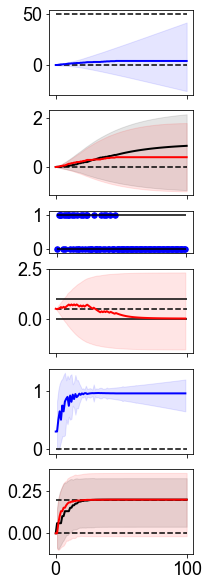

In [203]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams["font.size"] = 18
o_fig = plt.figure(figsize=(4,10))


o_spec = gridspec.GridSpec(ncols=1, nrows=6, height_ratios=[2,2,1,2,2,2])


o_ax_l = []
o_ax_l.append(o_fig.add_subplot(o_spec[0]))
o_ax_l.append(o_fig.add_subplot(o_spec[1]))
o_ax_l.append(o_fig.add_subplot(o_spec[2]))
o_ax_l.append(o_fig.add_subplot(o_spec[3]))
o_ax_l.append(o_fig.add_subplot(o_spec[4]))
o_ax_l.append(o_fig.add_subplot(o_spec[5]))

CL = 0.95# Confidencial Level for Figures
Df = N_exp-1# degree of freedom for Figures

o_mean = [] #mean at t
o_STD = []
#SE = []# Standard Error for Figures
o_CI = np.zeros((7, N_i+1, 2)) #confidence intervals at t


for j, h in zip(['H','Q0','Q1','P','R', 'Kh0','Kh1'], list(range(7))):
    for i in range(N_i+1):
        o_mean.append(sum(o_df.loc[o_df['trial']==i][j])/N_exp)
        o_STD.append(st.stdev(o_df.loc[o_df['trial']==i][j]))
        o_CI[h][i][0] = stats.t.interval(alpha = CL, df = Df, loc = o_mean[-1], scale = 2*o_STD[-1])[0]
        o_CI[h][i][1] = stats.t.interval(alpha = CL, df = Df, loc = o_mean[-1], scale = 2*o_STD[-1])[1]
        
         
length_l, length_s = N_i+1, N_i


o_ax_l[0].hlines(50, 0, N_i, linestyle="dashed")
o_ax_l[0].hlines(0, 0, N_i, linestyle="dashed")
o_ax_l[0].plot(o_df['H'][:length_l], linewidth=2, color='blue')
o_ax_l[0].fill_between(o_df.index[:length_l], o_CI[0, :, 0], o_CI[0, :, 1], color='blue', alpha=rd) #confidence interval curves.
#o_ax_l[0].set_ylabel('Internal state (H)', fontsize=fs, fontname='Arial')
o_ax_l[0].tick_params(labelbottom=False)


o_ax_l[1].hlines(0, 0, N_i, linestyle="dashed")
o_ax_l[1].plot(o_df['Q0'][:length_l], linewidth=2, color='black')
o_ax_l[1].fill_between(o_df.index[:length_l], o_CI[1, :, 0], o_CI[1, :, 1], color='black', alpha=rd) #confidence interval curves.
o_ax_l[1].plot(o_df['Q1'][:length_l], linewidth=2, color='red')
o_ax_l[1].fill_between(o_df.index[:length_l], o_CI[2, :, 0], o_CI[2, :, 1], color='red', alpha=rd) #confidence interval curves.
#o_ax_l[1].set_ylabel('Action values (Q)' , fontsize=fs, fontname='Arial')
o_ax_l[1].tick_params(labelbottom=False)


o_ax_l[2].hlines(1, 0, N_i)
o_ax_l[2].hlines(0, 0, N_i)
o_ax_l[2].scatter(list(range(length_s)), o_df['A'][:length_s], s=30, c='blue')
#o_ax_l[2].set_ylabel('Actions (a)' , fontsize=fs, fontname='Arial')
o_ax_l[2].tick_params(labelbottom=False)


o_ax_l[3].hlines(0, 0, N_i)
o_ax_l[3].hlines(0.5, 0, N_i,  linestyle="dashed")
o_ax_l[3].hlines(1, 0, N_i)
o_ax_l[3].plot(o_df['P'][:length_s], linewidth=2, color='red')
o_ax_l[3].fill_between(o_df.index[:length_s], o_CI[3, :, 0][:length_s], o_CI[3, :, 1][:length_s], color='red', alpha=rd) #confidence interval curves.
#o_ax_l[3].set_ylabel('Probability \n of intake (P)' , fontsize=fs, fontname='Arial')
o_ax_l[3].tick_params(labelbottom=False)


o_ax_l[4].hlines(0, 0, N_i, linestyle="dashed")
o_ax_l[4].plot(o_df['R'][:length_s], linewidth=2, color='blue')
o_ax_l[4].fill_between(o_df.index[:length_s], o_CI[4, :, 0][:length_s], o_CI[4, :, 1][:length_s], color='blue', alpha=rd) #confidence interval curves.
#o_ax_l[4].set_ylabel('Reward (R)' , fontsize=fs, fontname='Arial')
o_ax_l[4].tick_params(labelbottom=False)

o_ax_l[5].hlines(0, 0, N_i, linestyle="dashed")
o_ax_l[5].hlines(mouth, 0, N_i, linestyle="dashed")
o_ax_l[5].plot(o_df['Kh0'][:length_l], linewidth=2, color='black')
o_ax_l[5].fill_between(o_df.index[:length_l], o_CI[5, :, 0], o_CI[5, :, 1], color='black', alpha=rd) #confidence interval curves.
o_ax_l[5].plot(o_df['Kh1'][:length_l], linewidth=2, color='red')
o_ax_l[5].fill_between(o_df.index[:length_l], o_CI[6, :, 0], o_CI[6, :, 1], color='red', alpha=rd) #confidence interval curves.
#o_ax_l[5].set_ylabel('Oral sense (K^)' , fontsize=fs, fontname='Arial')
#ax_l[5].tick_params(labelbottom=False)

o_fig.subplots_adjust(left=0.4)
o_fig.savefig("Fig2_oral.png")


In [204]:
def count_a(all_a):
    sum_l = []
    for i in range(N_exp):
        sum_l.append(sum(all_a[i*N_i+i : i*N_i+i+N_i]))
    return sum_l
    

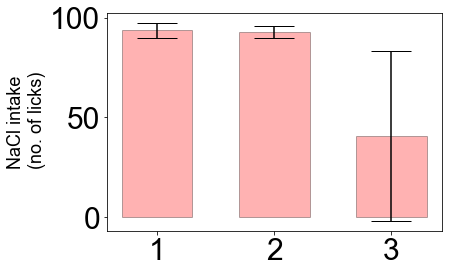

[93.52 92.59 40.68]


In [205]:
#散布図の作成
y1 = count_a(a_a)
y2 = count_a(ig_a_a)
y3 = count_a(o_a_a)

ave1 = np.average(y1)
ave2 = np.average(y2)
ave3 = np.average(y3)

std1 = np.std(y1)
std2 = np.std(y2)
std3 = np.std(y3)

x_ax = np.array([1,2,3])
y_ax = np.array([ave1, ave2, ave3])

plt.ylabel('NaCl intake\n (no. of licks)', fontsize=fs)
plt.bar(x_ax, y_ax, color="red", alpha=0.3, edgecolor="k", width=0.6, capsize=20
       , yerr=[std1,std2,std3])


plt.tick_params(labelsize=30)
plt.show()

print(y_ax)

# 今回の誤差は±標準偏差